This notebook shows the potential of Jupyer Labs for hosting the EDACAB hackathon.

We'll start by loading in some commonly used Python modules we need for processing and plotting the data.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import pandas as pd
import urllib  # the lib that handles the url stuff
from scipy.signal import welch


Now let's load the data from GitHub. This data is stored as a list of dictionaries. The code below loads the data and converts it to a nested dictionary.

In [41]:
url = "https://raw.githubusercontent.com/zwynne/EDACAB/main/Chongqing_data/Part_Sensor_record_data_data.txt"


data = urllib.request.urlopen(url).readlines() # it's a file like object and works just like a file

dat = list(map(json.loads, data))[0]

unique_conditions = np.unique([i['Working condition'] for i in dat])
dat0 = {}

for i in range(len(unique_conditions)):
    tmp = {}
    for entry in dat:
        if entry['Working condition']==unique_conditions[i]:
            tmp['Measuring point: '+entry['Measuring point']]=entry
    dat0['Working condition: '+unique_conditions[i]]=tmp
    del(entry,tmp)
del(i,dat,unique_conditions)



Let's see what working conditions are included.

In [43]:
working_conditions = list(dat0.keys())
print(working_conditions)

['Working condition: e1', 'Working condition: e2', 'Working condition: e3', 'Working condition: e4']


We'll check which measuing points we have for one of the working conditions.

In [45]:
measuring_points = list(dat0['Working condition: e1'].keys())
print(measuring_points)

['Measuring point: A10', 'Measuring point: A1', 'Measuring point: A2', 'Measuring point: A3', 'Measuring point: A4', 'Measuring point: A5', 'Measuring point: A6', 'Measuring point: A7', 'Measuring point: A8', 'Measuring point: A9', 'Measuring point: AY1', 'Measuring point: AY2', 'Measuring point: AY3', 'Measuring point: AY4', 'Measuring point: AY5', 'Measuring point: AY6', 'Measuring point: AY7', 'Measuring point: AZ2', 'Measuring point: AZ3', 'Measuring point: AZ4', 'Measuring point: AZ5', 'Measuring point: AZ6', 'Measuring point: AZ7', 'Measuring point: E11', 'Measuring point: E12', 'Measuring point: E13', 'Measuring point: E14', 'Measuring point: E15', 'Measuring point: E16', 'Measuring point: E17', 'Measuring point: E18', 'Measuring point: R1', 'Measuring point: R2']


Now let's plot all the Z direction measuring points measured responses alongside their Welch Power Spectral Density!

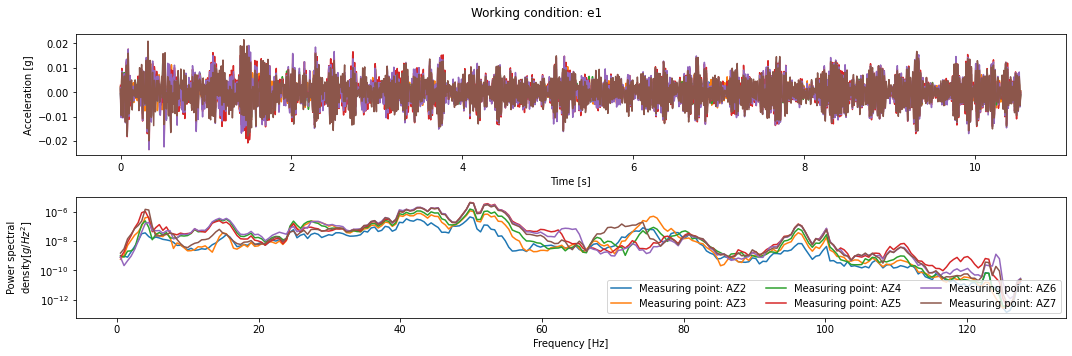

In [61]:
condition = 'Working condition: e1'

fg,ax = plt.subplots(2,figsize=(15,5))
for channel in measuring_points:
    f,psd = welch(dat0[condition][channel]['Acceleration'],fs=255.1,nperseg=512)
    channel_name = channel.split()[-1]
    if "Z" in channel_name:
        ax[0].plot(dat0[condition][channel]['Time [s]'],dat0[condition][channel]['Acceleration'],label=channel)
        ax[1].semilogy(f[1:],psd[1:],label=channel)
ax[0].set_ylabel('Acceleration [g]')
ax[1].set_ylabel('Power spectral\ndensity[$g/Hz^2$]')
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].legend(loc=4,ncol=3)
fg.suptitle(condition)
fg.tight_layout()